# XGBoost

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,  mean_squared_error
from sklearn.preprocessing import  LabelEncoder
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import pickle 


## Lectura de archivos

In [4]:
X_train = pd.read_csv("../../data/processed/X_train.csv")
y_train = pd.read_csv("../../data/processed/y_train.csv")["RUL_steps"].values
X_val = pd.read_csv("../../data/processed/X_val.csv")
y_val = pd.read_csv("../../data/processed/y_val.csv")["RUL_steps"].values
train_balanced =  pd.read_csv("../../data/processed/train_balanced.csv")
train_df = pd.read_csv("../../data/processed/train_df.csv")
val_df = pd.read_csv("../../data/processed/val_df.csv")

## Funciones

In [5]:
def prepare_data(df, num_features, cat_features):
    X = df[num_features + cat_features].copy()
    
    # Codificar categóricas
    for col in cat_features:
        if col in X.columns:
            X[col] = LabelEncoder().fit_transform(X[col].astype(str))
    
    # Manejar nulos
    X = X.fillna(X.median())
    
    y = df['RUL_steps']
    return X, y

###  XGBoost (n_estimators=500, depth=8)
**Decisión**: Hiperparámetros conservadores + sample_weight por riesgo.

**Justificación**:
- **Depth=8**: Balance complejidad/sobreajuste en 19 features.
- **Learning_rate=0.05**: Convergencia estable vs agresiva.
- **Pesos riesgo**: Refuerza aprendizaje MUY_CRITICO (8x), CRITICO (5x).
- **Subsample/colsample**: Reduce varianza overfitting.

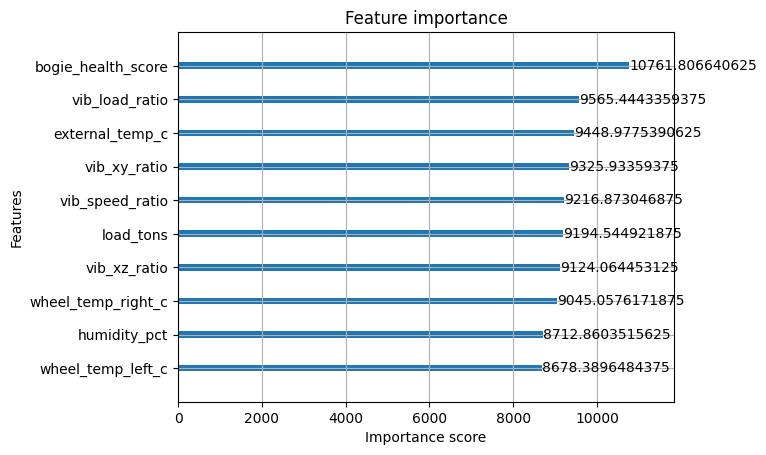

In [6]:
# ENTRENAR XGBoost 
weights = train_balanced['risk_bin'].map({
    'MUY_CRITICO': 8.0,
    'CRITICO': 5.0, 
    'ALTO_RIESGO': 2.0,
    'BAJO_RIESGO': 1.0
}).values

model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# entrenamiento
model.fit(X_train, y_train, sample_weight=weights)

#  Feature importance TOP 10
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.show()


In [7]:
#  EVALUAR
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)

In [8]:
print("y_val shape:", y_val.shape)
print("y_pred shape:", y_pred.shape)
print("y_val dtype:", y_val.dtype)
print("y_pred dtype:", y_pred.dtype)


y_val shape: (39683,)
y_pred shape: (39683,)
y_val dtype: int64
y_pred dtype: float32


In [9]:

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae_critico = mean_absolute_error(y_val[y_val<50], y_pred[y_val<50])

print(f"\n🎯 RESULTADOS EN VALIDACIÓN (desbalanceada):")
print(f"MAE total:      {mae:.0f}")
print(f"RMSE total:     {rmse:.0f}")
print(f"MAE RUL<50:     {mae_critico:.0f} ← ¡LO IMPORTANTE!")
print(f"% RUL<50:       {(y_val<50).mean():.1%}")


🎯 RESULTADOS EN VALIDACIÓN (desbalanceada):
MAE total:      35
RMSE total:     52
MAE RUL<50:     14 ← ¡LO IMPORTANTE!
% RUL<50:       62.1%


###  Interpretación operativa
**MAE=14 pasos en RUL<50** = detección fallos con ±14 registros antelación.

**Escenarios frecuencia muestreo**:
- 1h/registro → ±14 horas aviso
- 30min/registro → ±7 horas aviso  
- 10min/registro → ±2.3 horas aviso

In [10]:
#  MODELO ESPECIALIZADO para RUL_steps < 30 (CASOS MÁS CRÍTICOS)
mask_train_low = train_balanced['RUL_steps'] < 30
mask_val_low = val_df['RUL_steps'] < 30

X_train_low, y_train_low = X_train[mask_train_low], y_train[mask_train_low]
X_val_low, y_val_low = X_val[mask_val_low], y_val[mask_val_low]

print(f"Datos RUL_steps<30 - Train: {len(X_train_low):,} | Val: {len(X_val_low):,}")

# 2. XGBoost OPTIMIZADO para zona crítica
model_low = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

model_low.fit(X_train_low, y_train_low)

# 3. RESULTADOS ESPECIALIZADOS
y_pred_low = model_low.predict(X_val_low)
mae_low = mean_absolute_error(y_val_low, y_pred_low)
mae_low_critico = mean_absolute_error(y_val_low[y_val_low<10], y_pred_low[y_val_low<10])

print(f"\n🔥 MODELO ESPECIALIZADO RUL_steps<30:")
print(f"MAE RUL<30:     {mae_low:.1f}")
print(f"MAE RUL<10:     {mae_low_critico:.1f}")
print(f"Rango val:      {y_val_low.min():.0f}-{y_val_low.max():.0f}")

Datos RUL_steps<30 - Train: 69,056 | Val: 17,451

🔥 MODELO ESPECIALIZADO RUL_steps<30:
MAE RUL<30:     7.4
MAE RUL<10:     8.9
Rango val:      0-29


🔍 TOP 10 FEATURES MÁS IMPORTANTES (modelo general):
               feature  importance
11  bogie_health_score      0.0673
14      vib_load_ratio      0.0598
8      external_temp_c      0.0591
12        vib_xy_ratio      0.0583
15     vib_speed_ratio      0.0576
7            load_tons      0.0575
13        vib_xz_ratio      0.0570
5   wheel_temp_right_c      0.0565
9         humidity_pct      0.0545
4    wheel_temp_left_c      0.0542


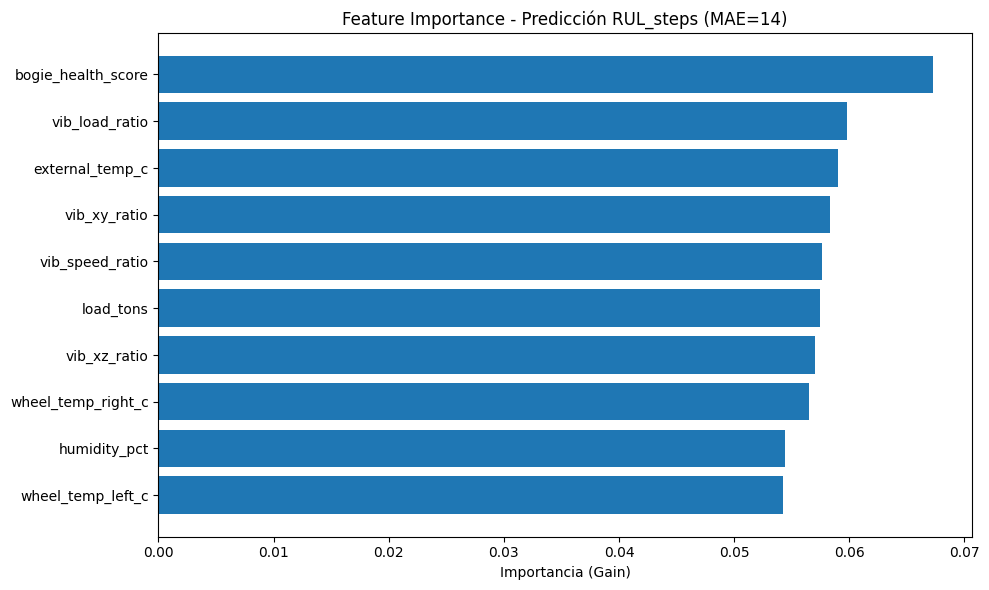


🏆 TOP 5:
           feature  importance
bogie_health_score    0.067266
    vib_load_ratio    0.059789
   external_temp_c    0.059061
      vib_xy_ratio    0.058291
   vib_speed_ratio    0.057610


In [11]:
# Feature importance del MODELO GENERAL (el que tiene MAE=14)
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("🔍 TOP 10 FEATURES MÁS IMPORTANTES (modelo general):")
print(importance_df.round(4))

# Gráfico horizontal
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title("Feature Importance - Predicción RUL_steps (MAE=14)")
plt.xlabel("Importancia (Gain)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# TOP 5 para referencia rápida
print("\n🏆 TOP 5:")
print(importance_df.head().to_string(index=False))


### Pickle

In [14]:
with open("../../models/xg_boost.pkl", "wb") as f:
    pickle.dump(model, f)

In [15]:
with open("../../models/xg_boost_low.pkl", "wb") as f:
    pickle.dump(model, f)